## Modelo Preditivo de Inadimplência em Empréstimos P2P

Modelo Preditivo de Inadimplência em Empréstimos P2P utilizando Algoritmos de Classificação Supervisionada

Theodoro Priosti de Almeida - RA: 10401614


Histórico:
- 02/11/2025 - Theodoro - Criação do pipeline de ML e preparação dos dados
- 05/11/2025 - Theodoro - Implementação dos modelos de classificação
- 07/11/2025 - Theodoro - Avaliação e comparação dos resultados
- 07/11/2025 - Theodoro - Análise de interpretabilidade

In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost imbalanced-learn shap tensorflow


Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import time
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score,
    precision_score, recall_score, accuracy_score
)
import shap

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
print("Carregando dataset")
df = pd.read_csv('data/lending_club_sampled.csv')

print(f"Shape: {df.shape}")
print(f"Memória: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head()


Carregando dataset
Shape: (22607, 151)
Memória: 62.90 MB


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,121917586,NaN,5000.0,5000.0,5000.000000,36 months,22.91,193.32,E,E1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,84064163,NaN,10800.0,10800.0,10800.000000,60 months,13.49,248.46,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,89065844,NaN,5000.0,5000.0,5000.000000,36 months,8.99,158.98,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,16311550,NaN,21000.0,21000.0,21000.000000,60 months,14.99,499.48,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,77469812,NaN,21625.0,21625.0,21595.181105,36 months,11.47,712.80,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Criação da variável target
0 = Pago, 1 = Inadimplente


In [4]:
print("Status únicos:")
print(df['loan_status'].value_counts())

good_status = ['Fully Paid', 'Current', 'Does not meet the credit policy. Status:Fully Paid']
bad_status = ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)',
              'In Grace Period', 'Does not meet the credit policy. Status:Charged Off']

df_filtered = df[df['loan_status'].isin(good_status + bad_status)].copy()
df_filtered['target'] = df_filtered['loan_status'].apply(
    lambda x: 0 if x in good_status else 1
)

print(f"\nDataset filtrado: {df_filtered.shape[0]} registros")
print(f"\nDistribuição target:")
print(df_filtered['target'].value_counts())
print(df_filtered['target'].value_counts(normalize=True))


Status únicos:
loan_status
Fully Paid                                             10768
Current                                                 8783
Charged Off                                             2686
Late (31-120 days)                                       215
In Grace Period                                           84
Late (16-30 days)                                         43
Does not meet the credit policy. Status:Fully Paid        20
Does not meet the credit policy. Status:Charged Off        8
Name: count, dtype: int64

Dataset filtrado: 22607 registros

Distribuição target:
target
0    19571
1     3036
Name: count, dtype: int64
target
0    0.865705
1    0.134295
Name: proportion, dtype: float64


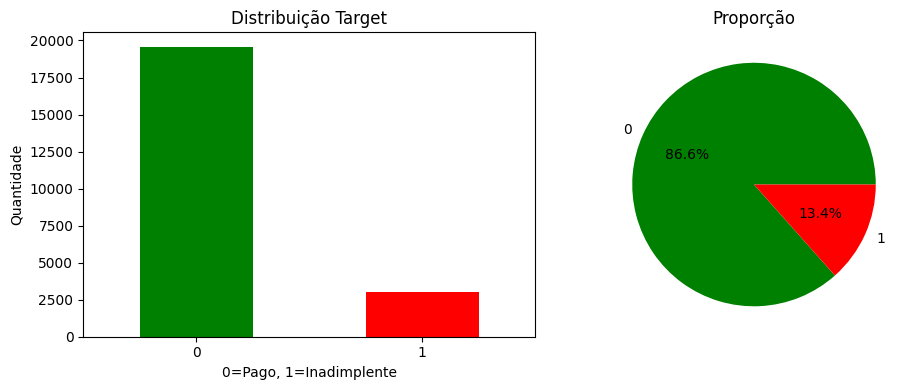

In [5]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df_filtered['target'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribuição Target')
plt.xlabel('0=Pago, 1=Inadimplente')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df_filtered['target'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Proporção')
plt.ylabel('')

plt.tight_layout()
plt.show()


Seleção de features


In [6]:
features_to_use = [
    'loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade',
    'term', 'purpose', 'home_ownership',
    'annual_inc', 'emp_length', 'verification_status',
    'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
    'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
    'revol_util', 'total_acc', 'mort_acc', 'issue_d'
]

features_available = [f for f in features_to_use if f in df_filtered.columns]

print(f"Features: {len(features_available)}")
print(features_available)

df_model = df_filtered[features_available + ['target']].copy()
print(f"\nDataset: {df_model.shape}")


Features: 23
['loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade', 'term', 'purpose', 'home_ownership', 'annual_inc', 'emp_length', 'verification_status', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'issue_d']

Dataset: (22607, 24)


In [7]:
missing = df_model.isnull().sum()
missing_pct = 100 * missing / len(df_model)
missing_df = pd.DataFrame({
    'Feature': missing.index,
    'Missing_Count': missing.values,
    'Missing_Pct': missing_pct.values
}).sort_values('Missing_Pct', ascending=False)

print("Valores ausentes:")
print(missing_df[missing_df['Missing_Pct'] > 0])

threshold_missing = 40
features_to_drop = missing_df[missing_df['Missing_Pct'] > threshold_missing]['Feature'].tolist()

if features_to_drop:
    print(f"\nRemovendo features >{threshold_missing}% missing:")
    print(features_to_drop)
    df_model = df_model.drop(columns=features_to_drop)

print(f"\nDataset: {df_model.shape}")


Valores ausentes:
       Feature  Missing_Count  Missing_Pct
9   emp_length           1515     6.701464
21    mort_acc            502     2.220551
19  revol_util             12     0.053081
11         dti             11     0.048657

Dataset: (22607, 24)


Feature engineering


In [ ]:
# FICO
if 'fico_range_low' in df_model.columns and 'fico_range_high' in df_model.columns:
    df_model['fico_avg'] = (df_model['fico_range_low'] + df_model['fico_range_high']) / 2
    print("Criado: fico_avg")

# empréstimo/renda
if 'loan_amnt' in df_model.columns and 'annual_inc' in df_model.columns:
    df_model['loan_to_income'] = df_model['loan_amnt'] / (df_model['annual_inc'] + 1)
    print("Criado: loan_to_income")

# Datas
if 'issue_d' in df_model.columns:
    df_model['issue_d'] = pd.to_datetime(df_model['issue_d'])
    df_model['issue_year'] = df_model['issue_d'].dt.year
    df_model['issue_month'] = df_model['issue_d'].dt.month
    df_model = df_model.drop('issue_d', axis=1)
    print("Criado: issue_year, issue_month")

# emp_length
if 'emp_length' in df_model.columns:
    df_model['emp_length_years'] = df_model['emp_length'].str.extract('(\d+)').astype(float)
    df_model['emp_length_years'] = df_model['emp_length_years'].fillna(0)
    df_model = df_model.drop('emp_length', axis=1)
    print("Criado: emp_length_years")

# term
if 'term' in df_model.columns:
    df_model['term_months'] = df_model['term'].str.extract('(\d+)').astype(int)
    df_model = df_model.drop('term', axis=1)
    print("Criado: term_months")

# int_rate
if 'int_rate' in df_model.columns and df_model['int_rate'].dtype == 'object':
    df_model['int_rate'] = df_model['int_rate'].str.rstrip('%').astype(float)
    print("Processado: int_rate")

# revol_util
if 'revol_util' in df_model.columns and df_model['revol_util'].dtype == 'object':
    df_model['revol_util'] = df_model['revol_util'].str.rstrip('%').astype(float)
    print("Processado: revol_util")

print(f"\nDataset após feature engineering: {df_model.shape}")


Criado: fico_avg
Criado: loan_to_income
Criado: issue_year, issue_month
Criado: emp_length_years
Criado: term_months

Dataset após feature engineering: (22607, 27)


7. Tratamento de Valores Ausentes e Encoding


In [50]:
numeric_features = df_model.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'target' in numeric_features:
    numeric_features.remove('target')  # Remover target

categorical_features = df_model.select_dtypes(include=['object']).columns.tolist()

print(f"Features numéricas: {len(numeric_features)}")
print(f"Features categóricas: {len(categorical_features)}")

for col in numeric_features:
    if df_model[col].isnull().sum() > 0:
        median_val = df_model[col].median()
        df_model[col].fillna(median_val, inplace=True)
        print(f"Preenchido {col} com mediana: {median_val:.2f}")

for col in categorical_features:
    if df_model[col].isnull().sum() > 0:
        mode_val = df_model[col].mode()[0]
        df_model[col].fillna(mode_val, inplace=True)
        print(f"Preenchido {col} com moda: {mode_val}")

print("\n One-Hot Encoding")
df_encoded = pd.get_dummies(df_model, columns=categorical_features, drop_first=True)

print(f"Dataset após encoding: {df_encoded.shape}")
print(f"Total de features: {df_encoded.shape[1] - 1}")


Features numéricas: 19
Features categóricas: 5

 One-Hot Encoding
Dataset após encoding: (22607, 81)
Total de features: 80


8. Tratamento de Outliers



In [51]:
# IQR
def remove_outliers_iqr(df, columns, multiplier=3):
    df_clean = df.copy()
    initial_len = len(df_clean)

    for col in columns:
        if col not in df_clean.columns:
            continue
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()

        if outliers > 0:
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
            print(f"  {col}: removidos {outliers} outliers")

    removed = initial_len - len(df_clean)
    print(f"\nRegistros removidos: {removed} ({100*removed/initial_len:.2f}%)")

    return df_clean

outlier_features = ['loan_amnt', 'annual_inc', 'dti', 'revol_bal']

df_clean = remove_outliers_iqr(df_encoded, outlier_features, multiplier=3)

print(f"\nDataset final: {df_clean.shape}")


  annual_inc: removidos 332 outliers
  dti: removidos 76 outliers
  revol_bal: removidos 465 outliers

Registros removidos: 873 (3.86%)

Dataset final: (21734, 81)


9. Separação de Features e Target


In [53]:
X = df_clean.drop('target', axis=1)
y = df_clean['target']

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nDistribuição do target no dataset limpo:")
print(y.value_counts())
print(f"\nProporção:")
print(y.value_counts(normalize=True))


Shape de X: (21734, 80)
Shape de y: (21734,)

Distribuição do target no dataset limpo:
target
0    18782
1     2952
Name: count, dtype: int64

Proporção:
target
0    0.864176
1    0.135824
Name: proportion, dtype: float64


10. Divisão em Treino, Validação e Teste



In [56]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"Treino: {X_train.shape[0]} amostras ({100*len(X_train)/len(X):.1f}%)")
print(f"Validação: {X_val.shape[0]} amostras ({100*len(X_val)/len(X):.1f}%)")
print(f"Teste: {X_test.shape[0]} amostras ({100*len(X_test)/len(X):.1f}%)")

print(f"\nDistribuição do target no treino:")
print(y_train.value_counts(normalize=True))
print(f"\nDistribuição do target na validação:")
print(y_val.value_counts(normalize=True))
print(f"\nDistribuição do target no teste:")
print(y_test.value_counts(normalize=True))


Treino: 15213 amostras (70.0%)
Validação: 3260 amostras (15.0%)
Teste: 3261 amostras (15.0%)

Distribuição do target no treino:
target
0    0.864195
1    0.135805
Name: proportion, dtype: float64

Distribuição do target na validação:
target
0    0.86411
1    0.13589
Name: proportion, dtype: float64

Distribuição do target no teste:
target
0    0.864152
1    0.135848
Name: proportion, dtype: float64


11. Normalização dos Dados



In [57]:
scaler = StandardScaler()

# Fit
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Converter para DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features normalizadas com StandardScaler")
print(f"\nEstatísticas após normalização (treino):")
print(f"  Média: {X_train_scaled.mean().mean():.6f}")
print(f"  Desvio padrão: {X_train_scaled.std().mean():.6f}")


Features normalizadas com StandardScaler

Estatísticas após normalização (treino):
  Média: -0.000000
  Desvio padrão: 1.000033


12. Balanceamento de Classes com SMOTE



In [59]:
# SMOTE
print(f"\nAntes do SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nDepois do SMOTE:")
print(pd.Series(y_train_balanced).value_counts())
print(f"\nDataset balanceado: {X_train_balanced.shape}")



Antes do SMOTE:
target
0    13147
1     2066
Name: count, dtype: int64

Depois do SMOTE:
target
1    13147
0    13147
Name: count, dtype: int64

Dataset balanceado: (26294, 80)


13. Resumo da Preparação dos Dados


In [68]:
print(f"Dataset Original: {df.shape}")
print(f"Dataset Filtrado (status definitivos): {df_filtered.shape}")
print(f"Features Selecionadas: {len(features_available)}")
print(f"Após Feature Engineering: {df_encoded.shape}")
print(f"Após Remoção de Outliers: {df_clean.shape}")
print(f"Features Finais: {X.shape[1]}")

print(f"\nDivisão dos Dados:")
print(f"   - Treino: {X_train.shape[0]}")
print(f"   - Validação: {X_val.shape[0]}")
print(f"   - Teste: {X_test.shape[0]}")

print(f"\nApós SMOTE: {X_train_balanced.shape[0]}")

print(f"\nTaxa de Inadimplência:")
print(f"   - Original: {100*y.mean():.2f}%")
print(f"   - Treino (pós-SMOTE): {100*pd.Series(y_train_balanced).mean():.2f}%")
print(f"   - Validação: {100*y_val.mean():.2f}%")
print(f"   - Teste: {100*y_test.mean():.2f}%")

Dataset Original: (22607, 151)
Dataset Filtrado (status definitivos): (22607, 152)
Features Selecionadas: 23
Após Feature Engineering: (22607, 81)
Após Remoção de Outliers: (21734, 81)
Features Finais: 80

Divisão dos Dados:
   - Treino: 15213
   - Validação: 3260
   - Teste: 3261

Após SMOTE: 26294

Taxa de Inadimplência:
   - Original: 13.58%
   - Treino (pós-SMOTE): 50.00%
   - Validação: 13.59%
   - Teste: 13.58%


IMPLEMENTAÇÃO DOS MODELOS

14. Modelo 1: Regressão Logística (Baseline)



In [ ]:
print("MODELO 1: REGRESSÃO LOGÍSTICA")

start_time = time.time()

# parâmetros
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_base = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, n_jobs=-1)

print("Grid Search")
grid_search_lr = GridSearchCV(
    lr_base,
    param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train_balanced, y_train_balanced)

# Melhor modelo
lr_model = grid_search_lr.best_estimator_

print(f"Melhores params: {grid_search_lr.best_params_}")
print(f"Melhor AUC-ROC (CV): {grid_search_lr.best_score_:.4f}")

train_time_lr = time.time() - start_time
print(f"Tempo: {train_time_lr:.2f} segundos")


MODELO 1: REGRESSÃO LOGÍSTICA
Grid Search...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/glados/Documents/Code/Generic/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/Users/glados/Documents/Code/Generic/.conda/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/glados/Documents/Code/Generic/.conda/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/glados/Documents/Code/Generic/.conda/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/glados/Documents/Code/Generic/.conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 10.
  warnings.warn(
/Users/glados/Documents

Melhores params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor AUC-ROC (CV): 0.7384
Tempo: 19.13 segundos


In [70]:
y_pred_lr_val = lr_model.predict(X_val_scaled)
y_pred_proba_lr_val = lr_model.predict_proba(X_val_scaled)[:, 1]

print("AVALIAÇÃO")

print(f"\nAcurácia: {accuracy_score(y_val, y_pred_lr_val):.4f}")
print(f"Precisão: {precision_score(y_val, y_pred_lr_val):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_lr_val):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_lr_val):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba_lr_val):.4f}")

print(classification_report(y_val, y_pred_lr_val, target_names=['Pago', 'Inadimplente']))


AVALIAÇÃO

Acurácia: 0.6503
Precisão: 0.2219
Recall: 0.6275
F1-Score: 0.3278
AUC-ROC: 0.7050
              precision    recall  f1-score   support

        Pago       0.92      0.65      0.76      2817
Inadimplente       0.22      0.63      0.33       443

    accuracy                           0.65      3260
   macro avg       0.57      0.64      0.55      3260
weighted avg       0.82      0.65      0.70      3260



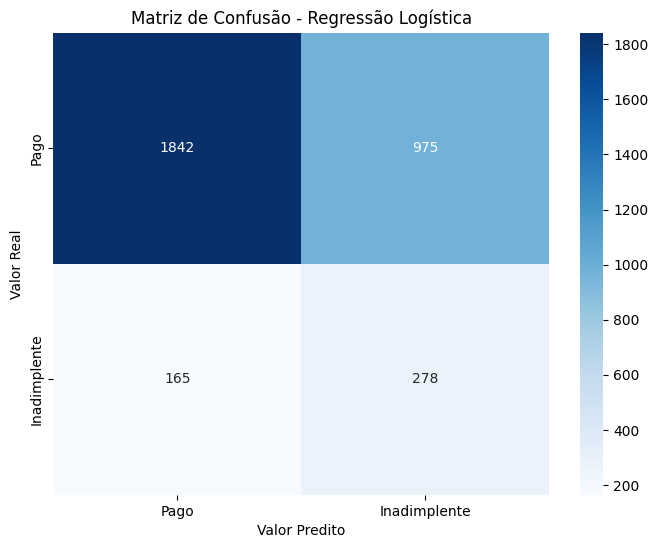

In [71]:
cm_lr = confusion_matrix(y_val, y_pred_lr_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pago', 'Inadimplente'],
            yticklabels=['Pago', 'Inadimplente'])
plt.title('Matriz de Confusão - Regressão Logística')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.show()


15. Modelo 2: Random Forest



In [ ]:
start_time = time.time()

# parâmetros
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight='balanced'
)

print("Grid Search")

grid_search_rf = GridSearchCV(
    rf_base,
    param_grid_rf,
    cv=2,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train_balanced, y_train_balanced)

# Melhor modelo
rf_model = grid_search_rf.best_estimator_

print(f"Melhores params: {grid_search_rf.best_params_}")
print(f"Melhor AUC-ROC (CV): {grid_search_rf.best_score_:.4f}")

train_time_rf = time.time() - start_time
print(f"Tempo: {train_time_rf:.2f} segundos")


MODELO 2: RANDOM FOREST
Grid Search (otimizado para Apple Silicon)...
Fitting 2 folds for each of 72 candidates, totalling 144 fits
Melhores params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Melhor AUC-ROC (CV): 0.9754
Tempo: 54.18 segundos


In [72]:
# Fazer predições
y_pred_rf_val = rf_model.predict(X_val_scaled)
y_pred_proba_rf_val = rf_model.predict_proba(X_val_scaled)[:, 1]

print(f"\nAcurácia: {accuracy_score(y_val, y_pred_rf_val):.4f}")
print(f"Precisão: {precision_score(y_val, y_pred_rf_val):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_rf_val):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_rf_val):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba_rf_val):.4f}")

print(classification_report(y_val, y_pred_rf_val, target_names=['Pago', 'Inadimplente']))



Acurácia: 0.8463
Precisão: 0.2364
Recall: 0.0587
F1-Score: 0.0940
AUC-ROC: 0.7103
              precision    recall  f1-score   support

        Pago       0.87      0.97      0.92      2817
Inadimplente       0.24      0.06      0.09       443

    accuracy                           0.85      3260
   macro avg       0.55      0.51      0.51      3260
weighted avg       0.78      0.85      0.80      3260



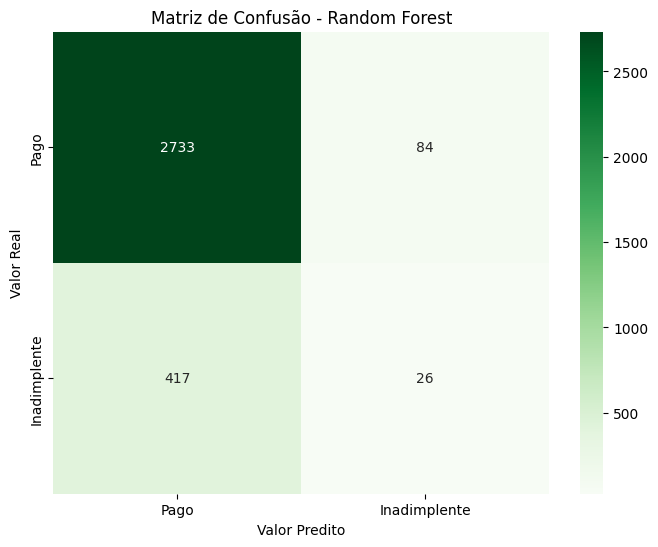

In [73]:
cm_rf = confusion_matrix(y_val, y_pred_rf_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pago', 'Inadimplente'],
            yticklabels=['Pago', 'Inadimplente'])
plt.title('Matriz de Confusão - Random Forest')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.show()


FEATURES MAIS IMPORTANTES
             feature  importance
17        issue_year    0.093410
1           int_rate    0.056491
8     inq_last_6mths    0.053378
19  emp_length_years    0.043995
15          fico_avg    0.037767
6     fico_range_low    0.037427
18       issue_month    0.036808
7    fico_range_high    0.035789
4                dti    0.033891
16    loan_to_income    0.033883
9           open_acc    0.031935
12        revol_util    0.031811
20       term_months    0.031492
11         revol_bal    0.031468
14          mort_acc    0.030587


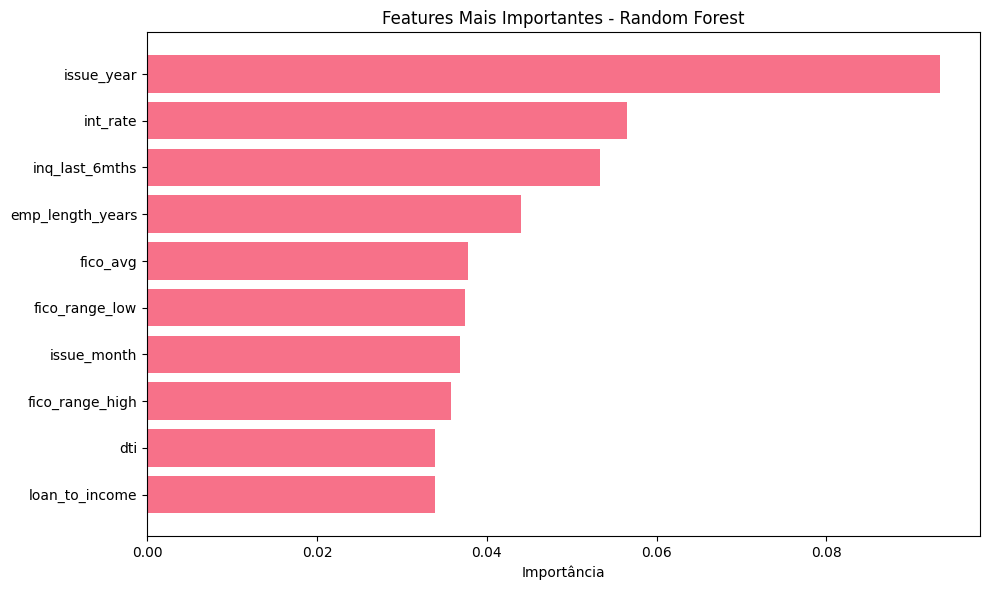

In [75]:
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("FEATURES MAIS IMPORTANTES")
print(feature_importance_rf.head(15))

plt.figure(figsize=(10, 6))
top_10 = feature_importance_rf.head(10)
plt.barh(range(len(top_10)), top_10['importance'])
plt.yticks(range(len(top_10)), top_10['feature'])
plt.xlabel('Importância')
plt.title('Features Mais Importantes - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


16. Modelo 3: XGBoost



In [ ]:
start_time = time.time()

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# parâmetros
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_base = XGBClassifier(
    random_state=RANDOM_STATE,
    tree_method='hist',
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)

grid_search_xgb = GridSearchCV(
    xgb_base,
    param_grid_xgb,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train_balanced, y_train_balanced)

# Melhor modelo
xgb_model = grid_search_xgb.best_estimator_

print(f"Melhores params: {grid_search_xgb.best_params_}")
print(f"Melhor AUC-ROC (CV): {grid_search_xgb.best_score_:.4f}")

train_time_xgb = time.time() - start_time
print(f"Tempo: {train_time_xgb:.2f} segundos")


MODELO 3: XGBOOST
Grid Search (otimizado para Apple Silicon)...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Melhores params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Melhor AUC-ROC (CV): 0.9584
Tempo: 35.25 segundos


In [77]:
y_pred_xgb_val = xgb_model.predict(X_val_scaled)
y_pred_proba_xgb_val = xgb_model.predict_proba(X_val_scaled)[:, 1]

print(f"\nAcurácia: {accuracy_score(y_val, y_pred_xgb_val):.4f}")
print(f"Precisão: {precision_score(y_val, y_pred_xgb_val):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_xgb_val):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_xgb_val):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba_xgb_val):.4f}")

print(classification_report(y_val, y_pred_xgb_val, target_names=['Pago', 'Inadimplente']))



Acurácia: 0.7880
Precisão: 0.2459
Recall: 0.2709
F1-Score: 0.2578
AUC-ROC: 0.6924
              precision    recall  f1-score   support

        Pago       0.88      0.87      0.88      2817
Inadimplente       0.25      0.27      0.26       443

    accuracy                           0.79      3260
   macro avg       0.56      0.57      0.57      3260
weighted avg       0.80      0.79      0.79      3260



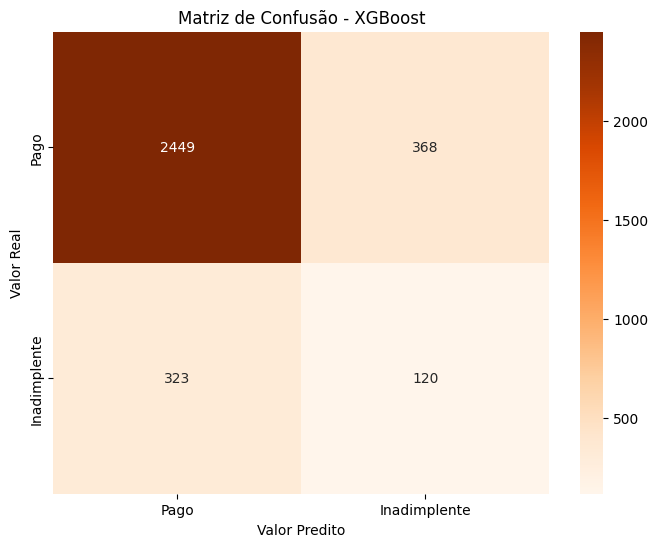

In [78]:
cm_xgb = confusion_matrix(y_val, y_pred_xgb_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Pago', 'Inadimplente'],
            yticklabels=['Pago', 'Inadimplente'])
plt.title('Matriz de Confusão - XGBoost')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.show()



FEATURES MAIS IMPORTANTES
                                feature  importance
17                           issue_year    0.105554
8                        inq_last_6mths    0.049712
79         verification_status_Verified    0.041704
20                          term_months    0.039375
78  verification_status_Source Verified    0.037438
74              home_ownership_MORTGAGE    0.028597
10                              pub_rec    0.027751
62           purpose_debt_consolidation    0.027033
14                             mort_acc    0.023871
5                           delinq_2yrs    0.022752
77                  home_ownership_RENT    0.021821
19                     emp_length_years    0.021604
72                     purpose_vacation    0.021514
1                              int_rate    0.020208
29                         sub_grade_A4    0.018257


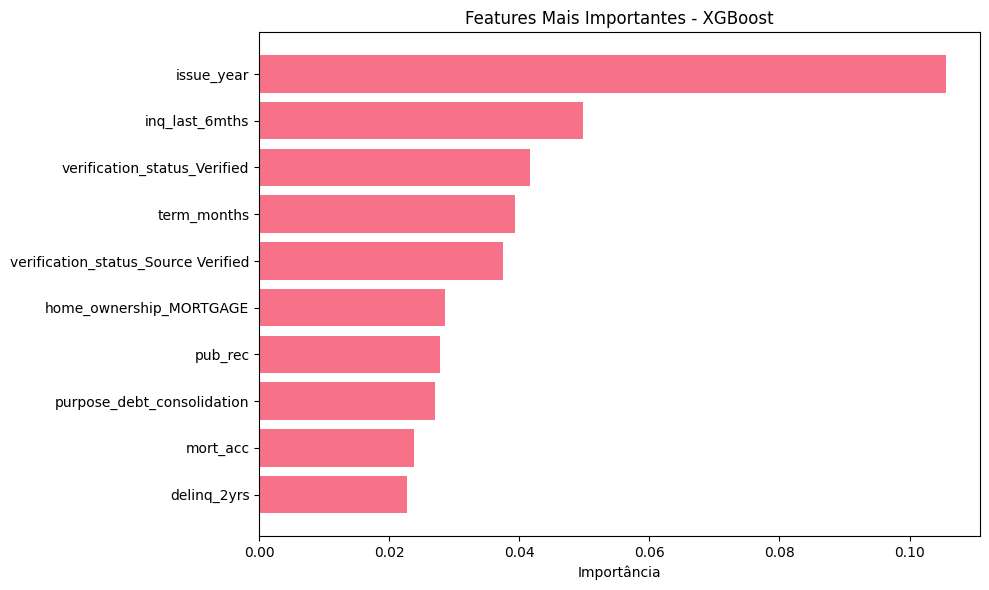

In [79]:
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("FEATURES MAIS IMPORTANTES")
print(feature_importance_xgb.head(15))

plt.figure(figsize=(10, 6))
top_10 = feature_importance_xgb.head(10)
plt.barh(range(len(top_10)), top_10['importance'])
plt.yticks(range(len(top_10)), top_10['feature'])
plt.xlabel('Importância')
plt.title('Features Mais Importantes - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


17. Modelo 4: Rede Neural Artificial (MLP)

Implementando MLP com TensorFlow/Keras otimizado para Apple Silicon (suporta Metal GPU se disponível).


In [ ]:
try:
    import tensorflow as tf
    print(f"\nTensorFlow version: {tf.__version__}")
    print(f"Dispositivos disponíveis: {len(tf.config.list_physical_devices())}")
    print(f"GPUs disponíveis: {len(tf.config.list_physical_devices('GPU'))}")
except:
    print("\nUsando CPU")

start_time = time.time()

n_features = X_train_balanced.shape[1]

mlp_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(n_features,)),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

mlp_model.summary()

MODELO 4: REDE NEURAL ARTIFICIAL (MLP)

TensorFlow version: 2.20.0
Dispositivos disponíveis: 1
GPUs disponíveis: 0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,737 (81.00 KB)

 Trainable params: 20,737 (81.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=3,
    mode='max',
    min_lr=0.00001,
    verbose=1
)

history = mlp_model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

train_time_mlp = time.time() - start_time
print(f"\nTempo de treinamento: {train_time_mlp:.2f} segundos")



Iniciando treinamento da Rede Neural...
Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6097 - auc: 0.6529 - loss: 0.6577 - val_accuracy: 0.6377 - val_auc: 0.7008 - val_loss: 0.5992 - learning_rate: 0.0010
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6637 - auc: 0.7208 - loss: 0.6158 - val_accuracy: 0.6365 - val_auc: 0.7031 - val_loss: 0.5880 - learning_rate: 0.0010
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6793 - auc: 0.7460 - loss: 0.5927 - val_accuracy: 0.6092 - val_auc: 0.7083 - val_loss: 0.6270 - learning_rate: 0.0010
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6910 - auc: 0.7574 - loss: 0.5814 - val_accuracy: 0.6417 - val_auc: 0.7088 - val_loss: 0.5850 - learning_rate: 0.0010
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7010 - auc: 0.7703 - loss: 0.5670 - val_accuracy: 0.6383 - val_auc: 0.7128 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━

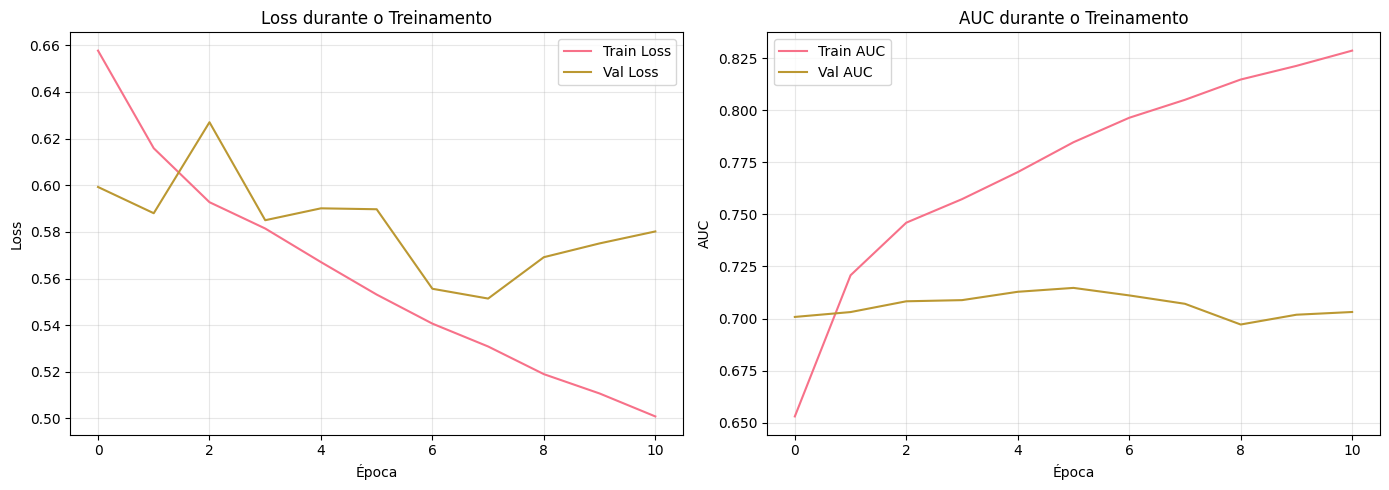

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Loss durante o Treinamento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['auc'], label='Train AUC')
axes[1].plot(history.history['val_auc'], label='Val AUC')
axes[1].set_title('AUC durante o Treinamento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('AUC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [81]:
y_pred_proba_mlp_val = mlp_model.predict(X_val_scaled).flatten()
y_pred_mlp_val = (y_pred_proba_mlp_val > 0.5).astype(int)

print(f"\nAcurácia: {accuracy_score(y_val, y_pred_mlp_val):.4f}")
print(f"Precisão: {precision_score(y_val, y_pred_mlp_val):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_mlp_val):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred_mlp_val):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba_mlp_val):.4f}")

print(classification_report(y_val, y_pred_mlp_val, target_names=['Pago', 'Inadimplente']))


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step

Acurácia: 0.6334
Precisão: 0.2223
Recall: 0.6795
F1-Score: 0.3350
AUC-ROC: 0.7147
              precision    recall  f1-score   support

        Pago       0.93      0.63      0.75      2817
Inadimplente       0.22      0.68      0.34       443

    accuracy                           0.63      3260
   macro avg       0.57      0.65      0.54      3260
weighted avg       0.83      0.63      0.69      3260



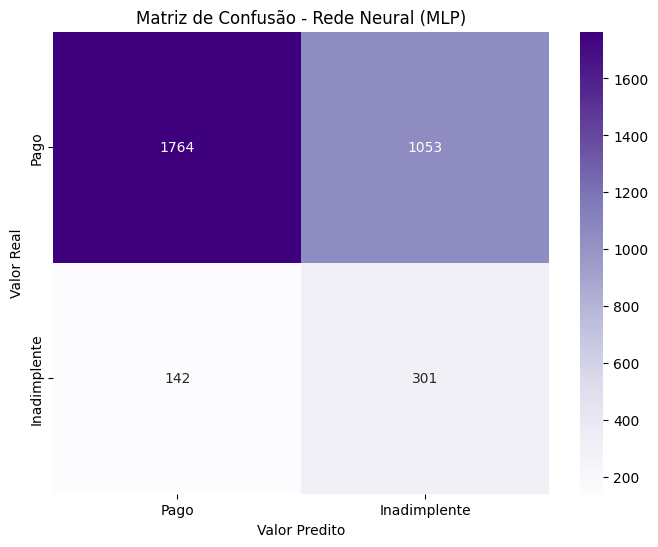

In [82]:
cm_mlp = confusion_matrix(y_val, y_pred_mlp_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Pago', 'Inadimplente'],
            yticklabels=['Pago', 'Inadimplente'])
plt.title('Matriz de Confusão - Rede Neural (MLP)')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.show()


PARTE 3: COMPARAÇÃO E ANÁLISE DOS MODELOS

18. Comparação de Performance dos Modelos


In [83]:
models_comparison = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest', 'XGBoost', 'Rede Neural (MLP)'],
    'Acurácia': [
        accuracy_score(y_val, y_pred_lr_val),
        accuracy_score(y_val, y_pred_rf_val),
        accuracy_score(y_val, y_pred_xgb_val),
        accuracy_score(y_val, y_pred_mlp_val)
    ],
    'Precisão': [
        precision_score(y_val, y_pred_lr_val),
        precision_score(y_val, y_pred_rf_val),
        precision_score(y_val, y_pred_xgb_val),
        precision_score(y_val, y_pred_mlp_val)
    ],
    'Recall': [
        recall_score(y_val, y_pred_lr_val),
        recall_score(y_val, y_pred_rf_val),
        recall_score(y_val, y_pred_xgb_val),
        recall_score(y_val, y_pred_mlp_val)
    ],
    'F1-Score': [
        f1_score(y_val, y_pred_lr_val),
        f1_score(y_val, y_pred_rf_val),
        f1_score(y_val, y_pred_xgb_val),
        f1_score(y_val, y_pred_mlp_val)
    ],
    'AUC-ROC': [
        roc_auc_score(y_val, y_pred_proba_lr_val),
        roc_auc_score(y_val, y_pred_proba_rf_val),
        roc_auc_score(y_val, y_pred_proba_xgb_val),
        roc_auc_score(y_val, y_pred_proba_mlp_val)
    ],
    'Tempo Treino (s)': [train_time_lr, train_time_rf, train_time_xgb, train_time_mlp]
})

print(models_comparison.to_string(index=False))

best_model_idx = models_comparison['AUC-ROC'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Modelo']
best_auc = models_comparison.loc[best_model_idx, 'AUC-ROC']

print(f"\nMelhor modelo: {best_model_name} (AUC-ROC: {best_auc:.4f})")


             Modelo  Acurácia  Precisão   Recall  F1-Score  AUC-ROC  Tempo Treino (s)
Regressão Logística  0.650307  0.221868 0.627540  0.327830 0.704998         19.128585
      Random Forest  0.846319  0.236364 0.058691  0.094033 0.710349         54.177195
            XGBoost  0.788037  0.245902 0.270880  0.257787 0.692372         35.254587
  Rede Neural (MLP)  0.633436  0.222304 0.679458  0.335003 0.714719          2.270665

Melhor modelo: Rede Neural (MLP) (AUC-ROC: 0.7147)


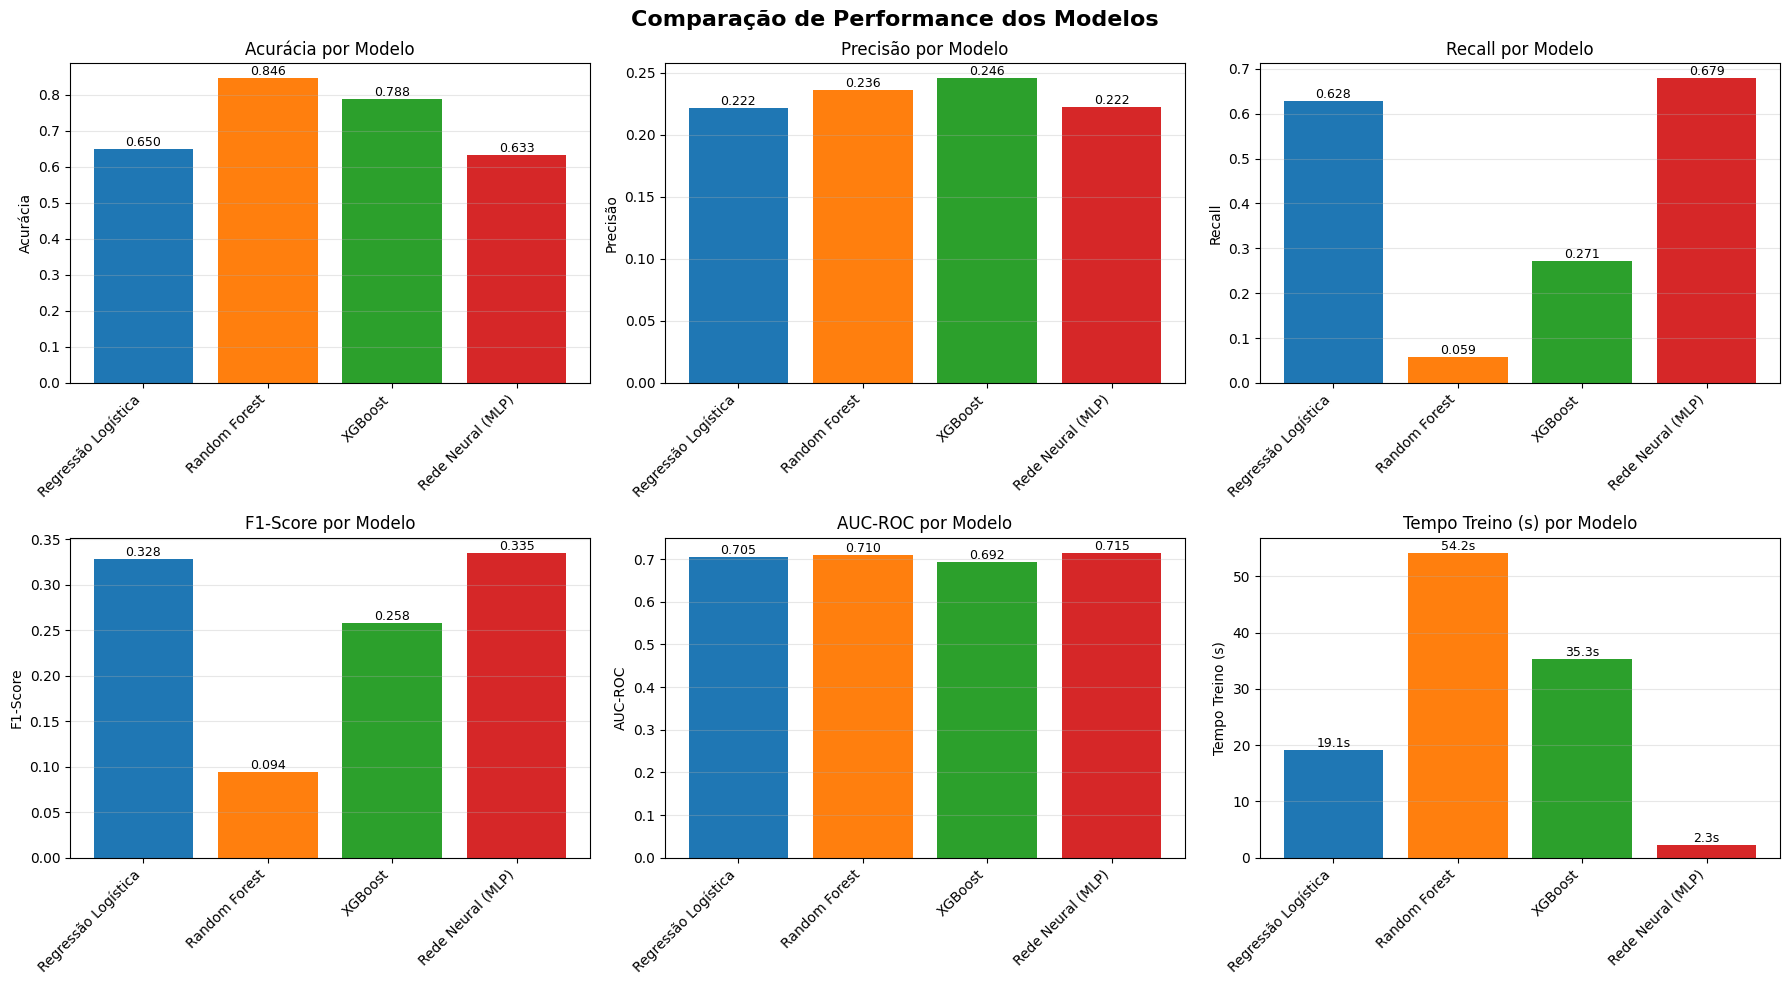

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparação de Performance dos Modelos', fontsize=16, fontweight='bold')

metrics = ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'AUC-ROC', 'Tempo Treino (s)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    bars = ax.bar(range(len(models_comparison)), models_comparison[metric], color=colors)
    ax.set_xticks(range(len(models_comparison)))
    ax.set_xticklabels(models_comparison['Modelo'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} por Modelo')
    ax.grid(True, alpha=0.3, axis='y')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        if metric == 'Tempo Treino (s)':
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}s',
                   ha='center', va='bottom', fontsize=9)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


19. Curvas ROC Comparativas


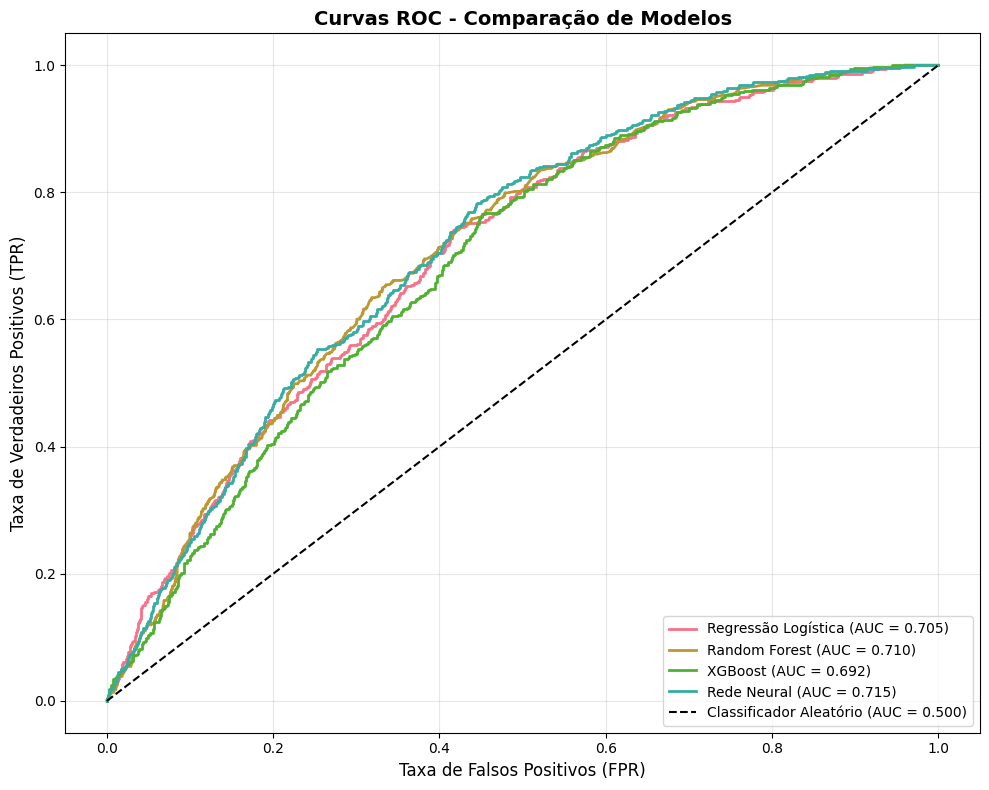

In [86]:
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_proba_lr_val)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf_val)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_proba_xgb_val)
fpr_mlp, tpr_mlp, _ = roc_curve(y_val, y_pred_proba_mlp_val)

plt.figure(figsize=(10, 8))

plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {roc_auc_score(y_val, y_pred_proba_lr_val):.3f})',
         linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_val, y_pred_proba_rf_val):.3f})',
         linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_val, y_pred_proba_xgb_val):.3f})',
         linewidth=2)
plt.plot(fpr_mlp, tpr_mlp, label=f'Rede Neural (AUC = {roc_auc_score(y_val, y_pred_proba_mlp_val):.3f})',
         linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório (AUC = 0.500)', linewidth=1.5)

plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=12)
plt.title('Curvas ROC - Comparação de Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


20. Matrizes de Confusão Comparativas


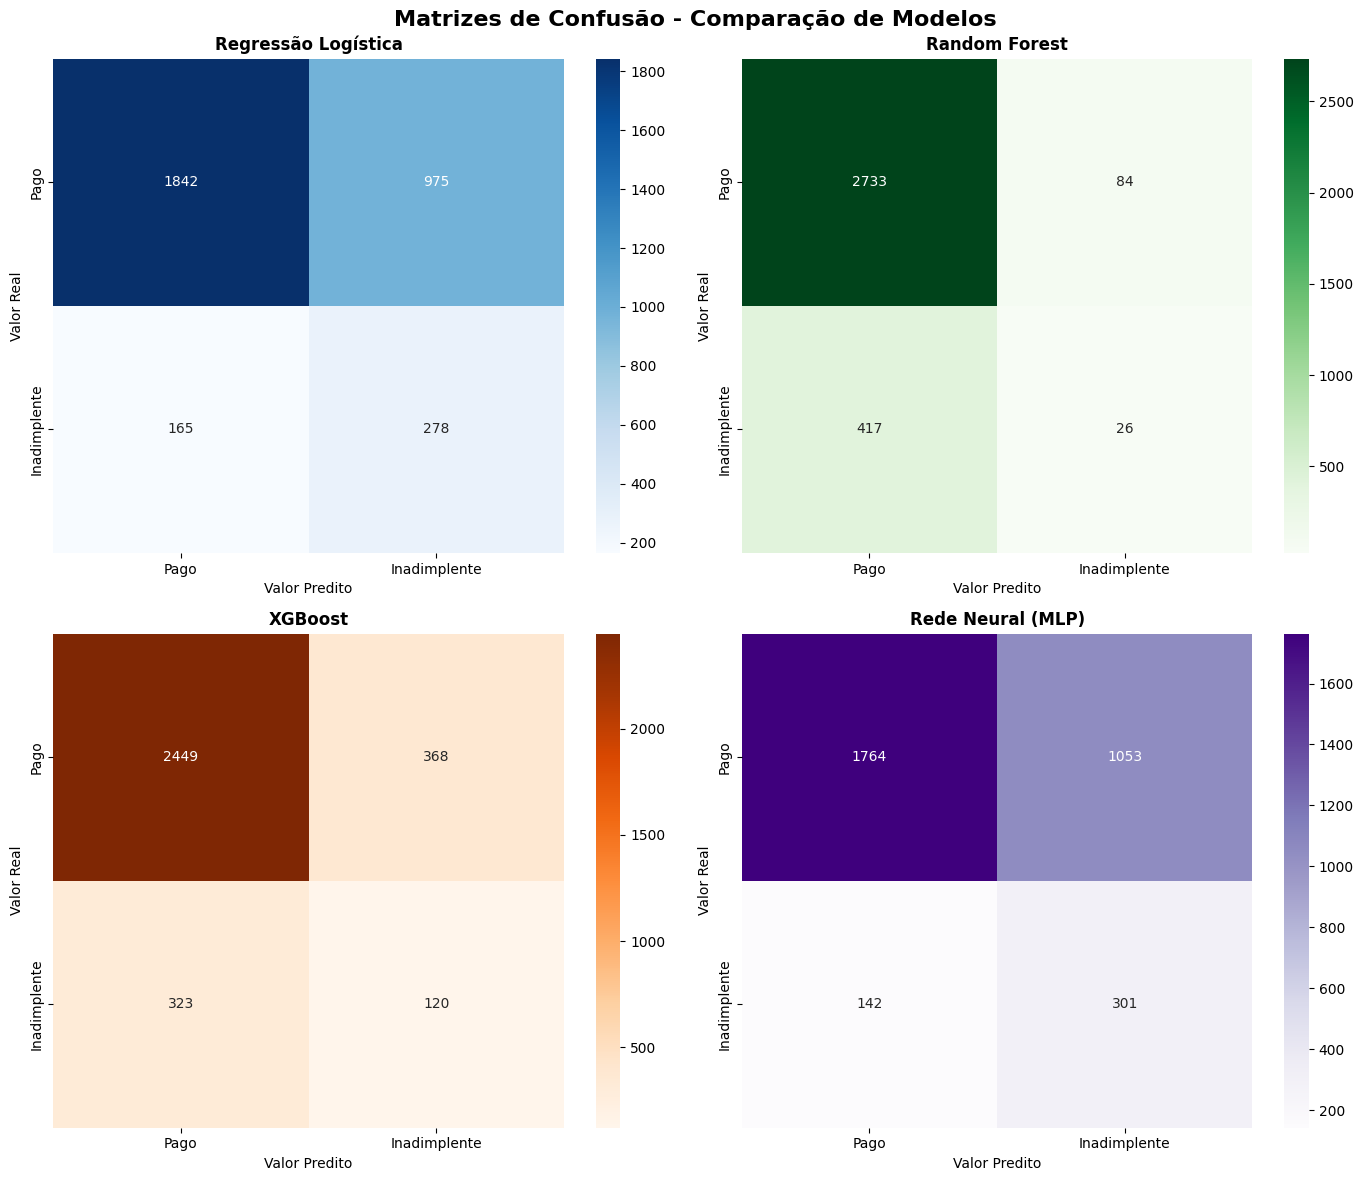

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Matrizes de Confusão - Comparação de Modelos', fontsize=16, fontweight='bold')

confusion_matrices = [
    (cm_lr, 'Regressão Logística', 'Blues'),
    (cm_rf, 'Random Forest', 'Greens'),
    (cm_xgb, 'XGBoost', 'Oranges'),
    (cm_mlp, 'Rede Neural (MLP)', 'Purples')
]

for idx, (cm, title, cmap) in enumerate(confusion_matrices):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=['Pago', 'Inadimplente'],
                yticklabels=['Pago', 'Inadimplente'])
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor Real')
    ax.set_xlabel('Valor Predito')

plt.tight_layout()
plt.show()

21. Análise de Interpretabilidade com SHAP



In [ ]:
if best_model_name == 'Regressão Logística':
    best_model = lr_model
    model_type = 'linear'
elif best_model_name == 'Random Forest':
    best_model = rf_model
    model_type = 'tree'
elif best_model_name == 'XGBoost':
    best_model = xgb_model
    model_type = 'tree'
else:  # Neural Network
    best_model = mlp_model
    model_type = 'deep'

print(f"\nAnalisando: {best_model_name}")

if model_type in ['tree']:
    explainer = shap.TreeExplainer(best_model)
    sample_size = min(1000, len(X_val_scaled))
    X_sample = X_val_scaled.sample(n=sample_size, random_state=RANDOM_STATE)
    shap_values = explainer.shap_values(X_sample)
elif model_type == 'deep':
    sample_size = min(500, len(X_val_scaled))
    X_sample = X_val_scaled.sample(n=sample_size, random_state=RANDOM_STATE)
    background = shap.sample(X_train_scaled, 100)
    explainer = shap.DeepExplainer(best_model, background.values)
    shap_values = explainer.shap_values(X_sample.values)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
else:
    sample_size = min(500, len(X_val_scaled))
    X_sample = X_val_scaled.sample(n=sample_size, random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(best_model.predict_proba, shap.sample(X_train_scaled, 100))
    shap_values = explainer.shap_values(X_sample)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

print(f"SHAP values calculados para {sample_size} amostras")


ANÁLISE SHAP - INTERPRETABILIDADE DO MODELO

Analisando: Rede Neural (MLP)
SHAP values calculados para 500 amostras


<Figure size 1200x800 with 0 Axes>

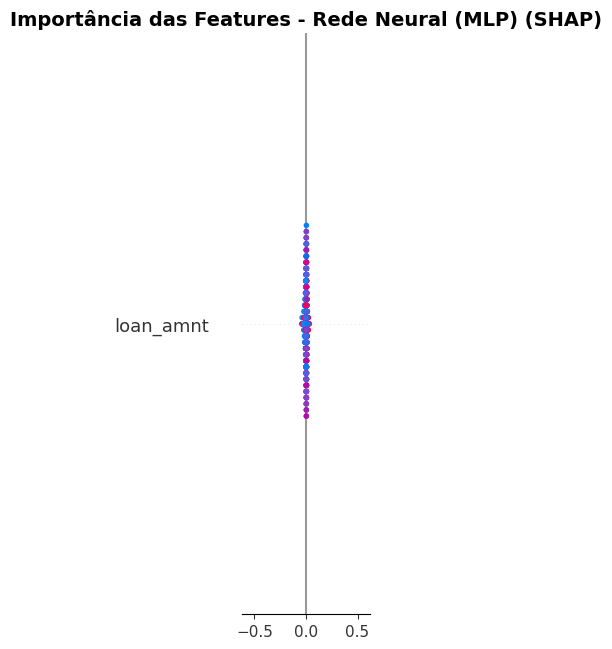

SHAP summary plot gerado!


In [ ]:
plt.figure(figsize=(12, 8))
if model_type == 'tree':
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title(f'Importância das Features - {best_model_name} (SHAP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

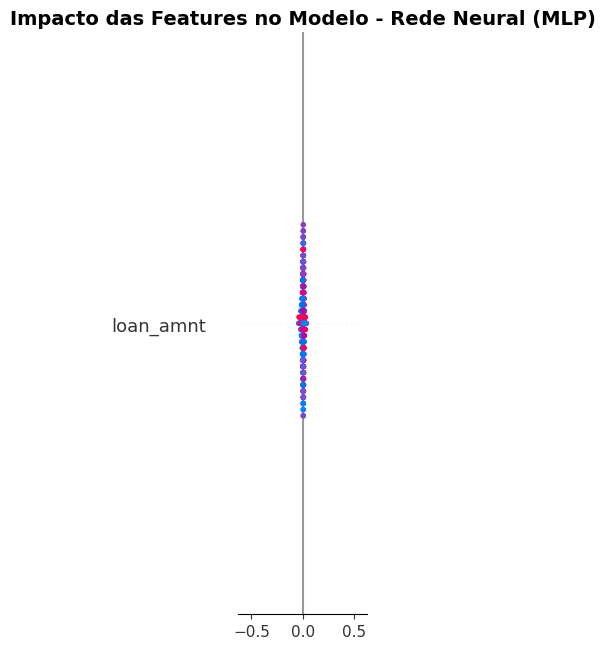

SHAP detailed plot gerado!


In [ ]:
plt.figure(figsize=(12, 10))
if model_type == 'tree':
    shap.summary_plot(shap_values, X_sample, show=False)
else:
    shap.summary_plot(shap_values, X_sample, show=False)
plt.title(f'Impacto das Features no Modelo - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [88]:
if model_type == 'tree':
    shap_importance = np.abs(shap_values).mean(axis=0)
else:
    shap_importance = np.abs(shap_values).mean(axis=0)

if shap_importance.ndim > 1:
    shap_importance = shap_importance.flatten()

feature_importance_shap = pd.DataFrame({
    'Feature': X_sample.columns,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)

print("FEATURES MAIS IMPORTANTES (SHAP)")
print(feature_importance_shap.head(10).to_string(index=False))


FEATURES MAIS IMPORTANTES (SHAP)
                     Feature  SHAP_Importance
                  issue_year         0.108545
                     grade_D         0.028671
                     grade_C         0.025169
verification_status_Verified         0.023086
                 issue_month         0.022381
                   revol_bal         0.021048
                    int_rate         0.018284
              inq_last_6mths         0.018000
         purpose_credit_card         0.016568
            emp_length_years         0.016137


22. Análise de Impacto de Negócio



In [89]:
if best_model_name == 'Regressão Logística':
    y_pred_best = y_pred_lr_val
    y_pred_proba_best = y_pred_proba_lr_val
elif best_model_name == 'Random Forest':
    y_pred_best = y_pred_rf_val
    y_pred_proba_best = y_pred_proba_rf_val
elif best_model_name == 'XGBoost':
    y_pred_best = y_pred_xgb_val
    y_pred_proba_best = y_pred_proba_xgb_val
else:
    y_pred_best = y_pred_mlp_val
    y_pred_proba_best = y_pred_proba_mlp_val

cm_best = confusion_matrix(y_val, y_pred_best)
tn, fp, fn, tp = cm_best.ravel()

print(f"\nAnálise da Matriz de Confusão:")
print(f"  Verdadeiros Negativos (TN): {tn} - Empréstimos pagos corretamente identificados")
print(f"  Falsos Positivos (FP): {fp} - Bons pagadores rejeitados (perda de oportunidade)")
print(f"  Falsos Negativos (FN): {fn} - Inadimplentes aprovados (perda direta)")
print(f"  Verdadeiros Positivos (TP): {tp} - Inadimplentes corretamente identificados")
avg_loan_amount = 15000
default_cost = avg_loan_amount
rejection_cost = avg_loan_amount * 0.05

# Calcular custos
cost_fp = fp * rejection_cost
cost_fn = fn * default_cost
total_cost = cost_fp + cost_fn

print(f"\nAnálise de Custo-Benefício (valores hipotéticos):")
print(f"  Valor médio de empréstimo: ${avg_loan_amount:,.2f}")
print(f"  Custo de Falsos Positivos: ${cost_fp:,.2f} ({fp} casos × ${rejection_cost:,.2f})")
print(f"  Custo de Falsos Negativos: ${cost_fn:,.2f} ({fn} casos × ${default_cost:,.2f})")
print(f"  Custo Total Estimado: ${total_cost:,.2f}")

# Comparar baseline
total_defaults = (y_val == 1).sum()
baseline_cost = total_defaults * default_cost

savings = baseline_cost - cost_fn
savings_pct = (savings / baseline_cost) * 100

print(f"\nComparação com Baseline (aprovar todos):")
print(f"  Custo Baseline: ${baseline_cost:,.2f}")
print(f"  Custo com Modelo: ${cost_fn:,.2f}")
print(f"  Economia: ${savings:,.2f} ({savings_pct:.1f}%)")



Análise da Matriz de Confusão:
  Verdadeiros Negativos (TN): 1764 - Empréstimos pagos corretamente identificados
  Falsos Positivos (FP): 1053 - Bons pagadores rejeitados (perda de oportunidade)
  Falsos Negativos (FN): 142 - Inadimplentes aprovados (perda direta)
  Verdadeiros Positivos (TP): 301 - Inadimplentes corretamente identificados

Análise de Custo-Benefício (valores hipotéticos):
  Valor médio de empréstimo: $15,000.00
  Custo de Falsos Positivos: $789,750.00 (1053 casos × $750.00)
  Custo de Falsos Negativos: $2,130,000.00 (142 casos × $15,000.00)
  Custo Total Estimado: $2,919,750.00

Comparação com Baseline (aprovar todos):
  Custo Baseline: $6,645,000.00
  Custo com Modelo: $2,130,000.00
  Economia: $4,515,000.00 (67.9%)


In [90]:
risk_bins = [0, 0.3, 0.5, 0.7, 1.0]
risk_labels = ['Baixo Risco', 'Médio Risco', 'Alto Risco', 'Muito Alto Risco']

risk_segments = pd.DataFrame({
    'Probabilidade': y_pred_proba_best,
    'Real': y_val.values
})

risk_segments['Categoria'] = pd.cut(risk_segments['Probabilidade'],
                                     bins=risk_bins,
                                     labels=risk_labels,
                                     include_lowest=True)
for category in risk_labels:
    segment = risk_segments[risk_segments['Categoria'] == category]
    if len(segment) > 0:
        total = len(segment)
        defaults = segment['Real'].sum()
        default_rate = (defaults / total) * 100

        print(f"\n{category}:")
        print(f"  Total de empréstimos: {total}")
        print(f"  Inadimplências: {defaults}")
        print(f"  Taxa de inadimplência: {default_rate:.2f}%")



Baixo Risco:
  Total de empréstimos: 1146
  Inadimplências: 47
  Taxa de inadimplência: 4.10%

Médio Risco:
  Total de empréstimos: 760
  Inadimplências: 95
  Taxa de inadimplência: 12.50%

Alto Risco:
  Total de empréstimos: 948
  Inadimplências: 188
  Taxa de inadimplência: 19.83%

Muito Alto Risco:
  Total de empréstimos: 406
  Inadimplências: 113
  Taxa de inadimplência: 27.83%


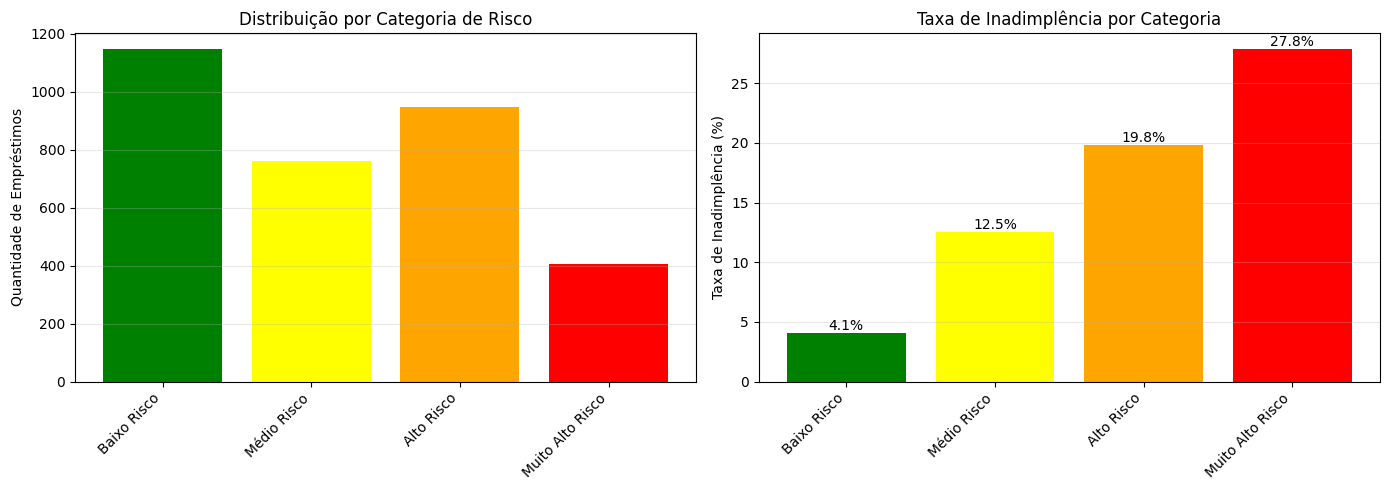

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(len(risk_labels)),
           [len(risk_segments[risk_segments['Categoria'] == cat]) for cat in risk_labels],
           color=['green', 'yellow', 'orange', 'red'])
axes[0].set_xticks(range(len(risk_labels)))
axes[0].set_xticklabels(risk_labels, rotation=45, ha='right')
axes[0].set_ylabel('Quantidade de Empréstimos')
axes[0].set_title('Distribuição por Categoria de Risco')
axes[0].grid(True, alpha=0.3, axis='y')

default_rates = [
    (risk_segments[risk_segments['Categoria'] == cat]['Real'].sum() /
     len(risk_segments[risk_segments['Categoria'] == cat]) * 100)
    if len(risk_segments[risk_segments['Categoria'] == cat]) > 0 else 0
    for cat in risk_labels
]

axes[1].bar(range(len(risk_labels)), default_rates,
           color=['green', 'yellow', 'orange', 'red'])
axes[1].set_xticks(range(len(risk_labels)))
axes[1].set_xticklabels(risk_labels, rotation=45, ha='right')
axes[1].set_ylabel('Taxa de Inadimplência (%)')
axes[1].set_title('Taxa de Inadimplência por Categoria')
axes[1].grid(True, alpha=0.3, axis='y')

for i, rate in enumerate(default_rates):
    axes[1].text(i, rate, f'{rate:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


23. Avaliação Final no Conjunto de Teste



AVALIAÇÃO FINAL - REDE NEURAL (MLP)
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
MÉTRICAS:
  Acurácia: 0.6293
  Precisão: 0.2276
  Recall: 0.7223
  F1-Score: 0.3461
  AUC-ROC: 0.7361
              precision    recall  f1-score   support

        Pago       0.93      0.61      0.74      2818
Inadimplente       0.23      0.72      0.35       443

    accuracy                           0.63      3261
   macro avg       0.58      0.67      0.54      3261
weighted avg       0.84      0.63      0.69      3261



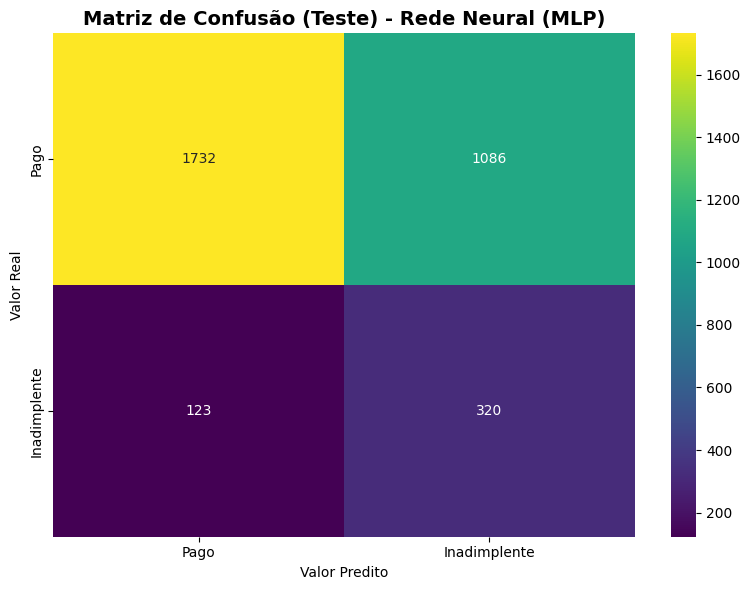

In [93]:
print(f"AVALIAÇÃO FINAL - {best_model_name.upper()}")

if best_model_name == 'Rede Neural (MLP)':
    y_pred_test = (best_model.predict(X_test_scaled).flatten() > 0.5).astype(int)
    y_pred_proba_test = best_model.predict(X_test_scaled).flatten()
else:
    y_pred_test = best_model.predict(X_test_scaled)
    y_pred_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]

print("MÉTRICAS:")
print(f"  Acurácia: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"  Precisão: {precision_score(y_test, y_pred_test):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_test, y_pred_proba_test):.4f}")

print(classification_report(y_test, y_pred_test, target_names=['Pago', 'Inadimplente']))

cm_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Pago', 'Inadimplente'],
            yticklabels=['Pago', 'Inadimplente'])
plt.title(f'Matriz de Confusão (Teste) - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.tight_layout()
plt.show()


24. Resumo Final e Conclusões


In [96]:
print("\nDADOS:")
print(f"   - Dataset Original: {df.shape[0]:,} empréstimos")
print(f"   - Dataset Processado: {df_clean.shape[0]:,} empréstimos")
print(f"   - Features Finais: {X.shape[1]}")
print(f"   - Taxa de Inadimplência: {100*y.mean():.2f}%")

print("\nMODELOS IMPLEMENTADOS:")
for i, model_name in enumerate(models_comparison['Modelo']):
    auc = models_comparison.loc[i, 'AUC-ROC']
    time_train = models_comparison.loc[i, 'Tempo Treino (s)']
    print(f"   - {model_name}: AUC-ROC = {auc:.4f} (Treino: {time_train:.1f}s)")

print(f"\nMELHOR MODELO:")
print(f"   {best_model_name}")
print(f"   - AUC-ROC (Validação): {models_comparison.loc[best_model_idx, 'AUC-ROC']:.4f}")
print(f"   - AUC-ROC (Teste): {roc_auc_score(y_test, y_pred_proba_test):.4f}")
print(f"   - Precisão (Teste): {precision_score(y_test, y_pred_test):.4f}")
print(f"   - Recall (Teste): {recall_score(y_test, y_pred_test):.4f}")
print(f"   - F1-Score (Teste): {f1_score(y_test, y_pred_test):.4f}")

print("\nIMPACTO DE NEGÓCIO:")
print(f"   - Redução estimada de perdas: {savings_pct:.1f}%")
print(f"   - Economia estimada: ${savings:,.2f}")
print(f"   - Total de empréstimos analisados: {len(y_val):,}")

print("\nFEATURES MAIS IMPORTANTES (SHAP):")
for i, row in feature_importance_shap.head(5).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['SHAP_Importance']:.4f}")


DADOS:
   - Dataset Original: 22,607 empréstimos
   - Dataset Processado: 21,734 empréstimos
   - Features Finais: 80
   - Taxa de Inadimplência: 13.58%

MODELOS IMPLEMENTADOS:
   - Regressão Logística: AUC-ROC = 0.7050 (Treino: 19.1s)
   - Random Forest: AUC-ROC = 0.7103 (Treino: 54.2s)
   - XGBoost: AUC-ROC = 0.6924 (Treino: 35.3s)
   - Rede Neural (MLP): AUC-ROC = 0.7147 (Treino: 2.3s)

MELHOR MODELO:
   Rede Neural (MLP)
   - AUC-ROC (Validação): 0.7147
   - AUC-ROC (Teste): 0.7361
   - Precisão (Teste): 0.2276
   - Recall (Teste): 0.7223
   - F1-Score (Teste): 0.3461

IMPACTO DE NEGÓCIO:
   - Redução estimada de perdas: 67.9%
   - Economia estimada: $4,515,000.00
   - Total de empréstimos analisados: 3,260

FEATURES MAIS IMPORTANTES (SHAP):
   18. issue_year: 0.1085
   24. grade_D: 0.0287
   23. grade_C: 0.0252
   80. verification_status_Verified: 0.0231
   19. issue_month: 0.0224
